# Privacy Preserving Machine Learning

Course taught by Aurélien Bellet

Course page: http://researchers.lille.inria.fr/abellet/teaching/private_machine_learning_course.html

# Practical session 4: Differentially Private SGD

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

## Datasets

**You are free to work with any binary classification dataset(s) you like** (you may use more than a single dataset). It is of course possible to work with the US Census dataset used in previous practicals, but you can find other datasets for instance on [OpenML](https://www.openml.org/), [UCI](https://archive.ics.uci.edu/ml/index.php), [sklearn](https://scikit-learn.org/stable/modules/classes.html?highlight=datasets#module-sklearn.datasets).

Good candidate datasets should have rather small dimension compared to the number of data points. Examples include US Census in one-hot encoded version (`name='a9a', version=1`), houses (`name='houses', version=2`) and electricity (`name='electricity', version=1`).

The code below loads the US Census dataset in one-hot encoded version.

In [2]:
X, y = fetch_openml(name='a9a', version=1, return_X_y=True, as_frame=False)
n, d = X.shape

# convert labels to -1, 1
c = np.unique(y)    
y[y==c[0]] = -1
y[y==c[1]] = 1
y = y.astype(float)

print(n, d)

48842 123


We first standardize features, then normalize each point to have unit norm.

In [3]:
if sp.sparse.issparse(X):
    scaler = StandardScaler(with_mean=False)
else:
    scaler = StandardScaler()
normalizer = Normalizer()
X = normalizer.transform(scaler.fit_transform(X))

We now split the dataset into a train and a test set. Feel free to adapt the size of the training set to your dataset.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
n_train = X_train.shape[0]

(39073, 123) (39073,) (9769, 123) (9769,)


## Question 1 (non-private SGD)

In this first question, we will implement our own simple version of SGD, as well as define our own sklearn-compatible $\ell_2$-regularized logistic regression estimator. This will be convenient when we will implement a differentially private version in Question 2.

Below, you are given several pieces of code:
1. A function `sgd` which implements SGD: it is meant to be generic in the sense that it takes as input a function `obj_and_grad` which computes the value and the gradient of the desired objective function. **This function has missing parts that you need to complete**.
2. A function `my_logistic_obj_and_grad` (adapted from [the version from sklearn](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf39bbdacd6ed713c00724f8f871d60370/sklearn/linear_model/_logistic.py#L84)) which computes the value and gradient of the logistic regression problem. You do not need to modify this function.
3. A class `MySGDLogisticRegression` which defines a sklearn estimator for logistic regression, where the model is fit using SGD using the previous two functions. You do not need to modify this function.

Spend a bit of time to get familiar with the code provided, then complete the missing bits in the `sgd` function. Make sure it works by trying it on the binary classification dataset that you previously loaded.

In [5]:
def sgd(X, y, gamma, n_iter, obj_and_grad, theta_init, n_batch=1, freq_obj_eval=10,
        n_obj_eval=1000, random_state=None):
    """Stochastic Gradient Descent (SGD) algorithm

    Parameters
    ----------
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1).
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    obj_and_grad : callable
        A function which takes as a vector of shape (p,), a dataset of shape (n_batch, d)
        and a label vector of shape (n_batch,), and returns the objective value and gradient.
    theta_init : array, shape (p,)
        The initial value for the model parameters
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objective
    random_state : int
        Random seed to make the algorithm deterministic


    Returns
    -------
    theta : array, shape=(p,)
        The final value of the model parameters
    obj_list : list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_obj_eval iterations
    """
    
    rng = np.random.RandomState(random_state)
    n, d = X.shape
    p = theta_init.shape[0]
    
    theta = theta_init.copy()

    # if a constant step size was provided, we turn it into a constant function
    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma
    
    # list to record the evolution of the objective (for plotting)
    obj_list = []
    # we draw a fixed subset of points to monitor the objective
    idx_eval = rng.randint(0, n, n_obj_eval)

    for t in range(n_iter):
        if t % freq_obj_eval == 0:
            # evaluate objective
            obj, _ = obj_and_grad(theta, X[idx_eval, :], y[idx_eval])
            obj_list.append(obj)
        
        # TO COMPLETE
        
    return theta, obj_list

In [6]:
from sklearn.linear_model._base import LinearClassifierMixin, SparseCoefMixin, BaseEstimator
from sklearn.utils.extmath import log_logistic, safe_sparse_dot
from sklearn.linear_model._logistic import _intercept_dot
from scipy.special import expit
from sklearn.utils.validation import check_X_y

def my_logistic_obj_and_grad(theta, X, y, lamb):
    """Computes the value and gradient of the objective function of logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = w (if no intercept), or theta = [w b] (if intercept)

    Parameters
    ----------
    theta_init : array, shape (d,) or (d+1,)
        The initial value for the model parameters. When an intercept is used, it corresponds to the last entry
    X : array, shape (n, d)
        The data
    y : array, shape (n,)
        Binary labels (-1, 1)
    lamb : float
        The L2 regularization parameter


    Returns
    -------
    obj : float
        The value of the objective function
    grad : array, shape (d,) or (d+1,)
        The gradient of the objective function
    """
    n_samples, n_features = X.shape
    grad = np.empty_like(theta)

    w, c, yz = _intercept_dot(theta, X, y)

    # Logistic loss is the negative of the log of the logistic function
    obj = -np.mean(log_logistic(yz)) + .5 * lamb * np.dot(w, w)

    z = expit(yz)
    z0 = (z - 1) * y

    grad[:n_features] = safe_sparse_dot(X.T, z0) / n_samples + lamb * w

    # Case where we fit the intercept
    if grad.shape[0] > n_features:
        grad[-1] = z0.sum() / n_samples
    return obj, grad


class MySGDLogisticRegression(BaseEstimator, LinearClassifierMixin, SparseCoefMixin):
    """Our own sklearn estimator for logistic regression defined as:
    min (1/n) \sum_i log_loss(theta;X[i,:],y[i]) + (lamb / 2) \|w\|^2,
    where theta = [w b]
    
    Parameters
    ----------
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    lamb : float
        The L2 regularization parameter
    n_batch : int
        Size of the mini-batch to use at each iteration of SGD.
    freq_obj_eval : int
        Specifies the frequency (in number of iterations) at which we compute the objective
    n_obj_eval : int
        The number of points on which we evaluate the objectuve
    random_state : int
        Random seed to make the algorithm deterministic
        
    Attributes
    ----------
    coef_ : (p,)
        The weights of the logistic regression model.
    intercept_ : (1,)
        The intercept term of the logistic regression model.
    obj_list_: list of length (n_iter / freq_obj_eval)
        A list containing the value of the objective function computed every freq_loss_eval iterations
    """
    
    def __init__(self, gamma, n_iter, lamb=0, n_batch=1, freq_obj_eval=10, n_obj_eval=1000, random_state=None):
        self.gamma = gamma
        self.n_iter = n_iter
        self.lamb = lamb
        self.n_batch = n_batch
        self.freq_obj_eval = freq_obj_eval
        self.n_obj_eval = n_obj_eval
        self.random_state = random_state
    
    def fit(self, X, y):
        
        # WARNING: assumes labels are -1, 1
        X, y = check_X_y(X, y, accept_sparse='csr', dtype=[np.float64, np.float32], order="C")
        self.classes_ = np.unique(y)    
                
        p = X.shape[1]
        theta_init = np.zeros(p+1) # initialize parameters to zero
        # define the function for value and gradient needed by SGD
        obj_grad = lambda theta, X, y: my_logistic_obj_and_grad(theta, X, y, lamb=self.lamb)
        theta, obj_list = sgd(X, y, self.gamma, self.n_iter, obj_grad, theta_init, self.n_batch,
                              self.freq_obj_eval, self.n_obj_eval, self.random_state)
        
        # save the learned model into the appropriate quantities used by sklearn
        self.intercept_ = np.expand_dims(theta[-1], axis=0)
        self.coef_ = np.expand_dims(theta[:-1], axis=0)
        
        # also save list of objective values during optimization for plotting
        self.obj_list_ = obj_list
        
        return self

Test accuracy 0.7606715119254785


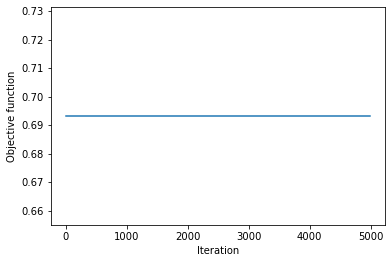

In [7]:
lamb = 0
n_iter = 5000
n_batch = 1
gamma = 0.05
# gamma = lambda t: 1 / np.sqrt(t)

mlr = MySGDLogisticRegression(gamma, n_iter, lamb, n_batch=n_batch, random_state=None)
mlr.fit(X_train, y_train)
print("Test accuracy", mlr.score(X_test, y_test))

obj_list = mlr.obj_list_
iter_list = np.arange(len(obj_list)) * mlr.freq_obj_eval
plt.plot(iter_list, obj_list)
plt.xlabel("Iteration")
plt.ylabel("Objective function")
plt.show()

## Question 2 (private SGD)

We will now implement and experiment with DP-SGD:
1. Following the model of the function `sgd`, implement a new function `private_sgd` which implements DP-SGD **with mini-batch size of 1 and no regularization**. It can take as input the desired value of $\epsilon$ and $\delta$ for the $(\epsilon,\delta)$-DP, or alternatively the standard deviation of the Gaussian noise to add at each iteration. Note: you do not need to make the objective plotting part private (this is only for monitoring).
2. Following the model of the class `MySGDLogisticRegression`, implement a new class `MyPrivateSGDLogisticRegression` which implements differentially private logistic regression trained using your DP-SGD implementation above.
3. Experiment with different values of $\epsilon$ and $\delta$, number of iterations and step size, and study the effect on the convergence of SGD as well as the test accuracy of the resulting model. Describe your observations. How should the number of iterations depend on the level of privacy? How can we choose the number of iterations and step size in practice?

## Question 3 (extending the scope of private SGD)

Let us consider the following extensions, which were briefly discussed in the lecture:
1. *$\ell_2$-regularization*: What is the sensitivity of the stochastic gradient when adding $\ell_2$-regularization to the objective (parameter `lamb` in the code above) ? Adapt your code if needed.
2. *Mini-batch*: What is the sensitivity of a stochastic gradient when it is evaluated on a mini-batch of $b$ data points (parameter `n_batch` in the code above) ? Adapt your code if needed.
3. *Gradient clipping*: If the loss function $L$ is not Lipschitz, or when the Lipschitz constant is difficult to bound, the idea of gradient clipping consists in rescaling each individual gradient that have a norm larger than some constant $C$ to have norm equal to $C$:
$$\text{clip}(\nabla L(\theta;x,y), C) = \min\Big(1,\frac{C}{\|\nabla L(\theta;x,y)\|_2}\Big)\nabla L(\theta;x,y)$$

Explain how this allows to bound the gradient sensitivity without any assumption on the Lipschitzness of the loss. Implement this variant in a function `private_sgd_with_clipping` and explore how to choose the value of $C$ for logistic regression on the *unnormalized* version of your dataset.

## Bonus Question 1 (DP-SGD for linear SVM)

Apply DP-SGD on linear SVM, which is obtained by replacing the logistic loss by the hinge loss $L(w,b;x,y)=\max(0, 1-y(w^Tx + b))$. For this, you need to implement a function `my_hinge_obj_and_grad` which computes the value and gradient of the objective function. Note that the hinge loss is differentiable everywhere, except at $0$ where it is sub-differentiable.

## Bonus Question 2 (DP-SGD for deep learning with TensorFlow Privacy)

[TensorFlow Privacy](https://github.com/tensorflow/privacy) contains implementations of TensorFlow optimizers for training machine learning models with differential privacy, in particular DP-SGD and its variants. You can install it by following the instructions given on GitHub (it is possible to install directly with `pip`).

Use TF Privacy to train a differentially private deep learning model on one of the image datasets provided in TF. To get familiar with TF Privacy, you may follow [this tutorial](https://github.com/tensorflow/privacy/blob/master/tutorials/walkthrough/README.md). 